In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## PROGSNAP CODE

[Data Information](https://sites.google.com/ncsu.edu/csedm-dc-2021/dataset?authuser=0)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import os
from os import path

In [ ]:
import pandas as pd
import os
from os import path


class PS2:
    """ A class holding constants used to get columns of a PS2 dataset
    """

    Order = 'Order'
    SubjectID = 'SubjectID'
    ToolInstances = 'ToolInstances'
    ServerTimestamp = 'ServerTimestamp'
    ServerTimezone = 'ServerTimezone'
    CourseID = 'CourseID'
    CourseSectionID = 'CourseSectionID'
    AssignmentID = 'AssignmentID'
    ProblemID = 'ProblemID'
    Attempt = 'Attempt'
    CodeStateID = 'CodeStateID'
    IsEventOrderingConsistent = 'IsEventOrderingConsistent'
    EventType = 'EventType'
    Score = 'Score'
    CompileResult = 'CompileResult'
    CompileMessageType = 'CompileMessageType'
    CompileMessageData = 'CompileMessageData'
    EventID = 'EventID'
    ParentEventID = 'ParentEventID'
    SourceLocation = 'SourceLocation'
    Code = 'Code'

    Version = 'Version'
    IsEventOrderingConsistent = 'IsEventOrderingConsistent'
    EventOrderScope = 'EventOrderScope'
    EventOrderScopeColumns = 'EventOrderScopeColumns'
    CodeStateRepresentation = 'CodeStateRepresentation'


class ProgSnap2Dataset:

    MAIN_TABLE_FILE = 'MainTable.csv'
    METADATA_TABLE_FILE = 'DatasetMetadata.csv'
    LINK_TABLE_DIR = 'LinkTables'
    CODE_STATES_DIR = 'CodeStates'
    CODE_STATES_TABLE_FILE = os.path.join(CODE_STATES_DIR, 'CodeStates.csv')

    def __init__(self, directory):
        self.directory = directory
        self.main_table = None
        self.metadata_table = None
        self.code_states_table = None

    def path(self, local_path):
        return path.join(self.directory, local_path)

    def get_main_table(self):
        """ Returns a Pandas DataFrame with the main event table for this dataset
        """
        if self.main_table is None:
            self.main_table = pd.read_csv(self.path(ProgSnap2Dataset.MAIN_TABLE_FILE))
            if self.get_metadata_property(PS2.IsEventOrderingConsistent):
                order_scope = self.get_metadata_property(PS2.EventOrderScope)
                if order_scope == 'Global':
                    # If the table is globally ordered, sort it
                    self.main_table.sort_values(by=[PS2.Order], inplace=True)
                elif order_scope == 'Restricted':
                    # If restricted ordered, sort first by grouping columns, then by order
                    order_columns = self.get_metadata_property(PS2.EventOrderScopeColumns)
                    if order_columns is None or len(order_columns) == 0:
                        raise Exception('EventOrderScope is restricted by no EventOrderScopeColumns given')
                    columns = order_columns.split(';')
                    columns.append('Order')
                    # The result is that _within_ these groups, events are ordered
                    self.main_table.sort_values(by=columns, inplace=True)
        return self.main_table.copy()

    def set_main_table(self, main_table):
        """ Overwrites the main table loaded from the file with the provided table.
        This this table will be used for future operations, including copying the dataset.
        """
        self.main_table = main_table.copy()

    def get_code_states_table(self):
        """ Returns a Pandas DataFrame with the code states table form this dataset
        """
        if self.code_states_table is None:
            self.code_states_table = pd.read_csv(self.path(ProgSnap2Dataset.CODE_STATES_TABLE_FILE))
        return self.code_states_table.copy()

    def get_metadata_property(self, property):
        """ Returns the value of a given metadata property in the metadata table
        """
        if self.metadata_table is None:
            self.metadata_table = pd.read_csv(self.path(ProgSnap2Dataset.METADATA_TABLE_FILE))

        values = self.metadata_table[self.metadata_table['Property'] == property]['Value']
        if len(values) == 1:
            return values.iloc[0]
        if len(values) > 1:
            raise Exception('Multiple values for property: ' + property)

        # Default return values as of V6
        if property == PS2.IsEventOrderingConsistent:
            return False
        if property == PS2.EventOrderScope:
            return 'None'
        if property == PS2.EventOrderScopeColumns:
            return ''

        return None

    def __link_table_path(self):
        return self.path(ProgSnap2Dataset.LINK_TABLE_DIR)

    def list_link_tables(self):
        """ Returns a list of the link tables in this dataset, which can be loaded with load_link_table
        """
        path = self.__link_table_path()
        dirs = os.listdir(path)
        return [f for f in dirs if os.path.isfile(os.path.join(path, f)) and f.endswith('.csv')]

    def load_link_table(self, link_table):
        """ Returns a Pandas DataFrame with the link table with the given name
        :param link_table: The link table nme or file
        """
        if not link_table.endswith('.csv'):
            link_table += '.csv'
        return pd.read_csv(path.join(self.__link_table_path(), link_table))

    def drop_main_table_column(self, column):
        self.get_main_table()
        self.main_table.drop(column, axis=1, inplace=True)

    def save_subset(self, path, main_table_filterer, copy_link_tables=True):
        os.makedirs(os.path.join(path, ProgSnap2Dataset.CODE_STATES_DIR), exist_ok=True)
        main_table = main_table_filterer(self.get_main_table())
        main_table.to_csv(os.path.join(path, ProgSnap2Dataset.MAIN_TABLE_FILE), index=False)
        code_state_ids = main_table[PS2.CodeStateID].unique()
        code_states = self.get_code_states_table()
        code_states = code_states[code_states[PS2.CodeStateID].isin(code_state_ids)]
        code_states.to_csv(os.path.join(path, ProgSnap2Dataset.CODE_STATES_DIR, 'CodeStates.csv'), index=False)
        self.metadata_table.to_csv(os.path.join(path, ProgSnap2Dataset.METADATA_TABLE_FILE), index=False)

        if not copy_link_tables:
            return

        os.makedirs(os.path.join(path, ProgSnap2Dataset.LINK_TABLE_DIR), exist_ok=True)

        def indexify(x):
            return tuple(x) if len(x) > 1 else x[0]

        for link_table_name in self.list_link_tables():
            link_table = self.load_link_table(link_table_name)
            columns = [col for col in link_table.columns if col.endswith('ID') and col in main_table.columns]
            distinct_ids = main_table.groupby(columns).apply(lambda x: True)
            # TODO: Still need to test this with multi-ID link tables
            to_keep = [indexify(list(row)) in distinct_ids for index, row in link_table[columns].iterrows()]
            filtered_link_table = link_table[to_keep]
            filtered_link_table.to_csv(os.path.join(path, ProgSnap2Dataset.LINK_TABLE_DIR, link_table_name), index=False)



    @staticmethod
    def __to_one(lst, error):
        if len(lst) == 0:
            return None
        if len(lst) > 1:
            raise Exception(error or 'Should have only one result!')
        return lst.iloc[0]

    def get_code_for_id(self, code_state_id):
        if code_state_id is None:
            return None
        code_states = self.get_code_states_table()
        code = code_states[code_states[PS2.CodeStateID] == code_state_id][PS2.Code]
        return ProgSnap2Dataset.__to_one(code, 'Multiple code states match that ID.')

    def get_code_for_event_id(self, row_id):
        events = self.get_main_table()
        code_state_ids = events[events[PS2.EventID == row_id]][PS2.CodeStateID]
        code_state_id = ProgSnap2Dataset.__to_one(code_state_ids, 'Multiple rows match that ID.')
        return self.get_code_for_id(code_state_id)

    def get_subject_ids(self):
        events = self.get_main_table()
        return events[PS2.SubjectID].unique()

    def get_problem_ids(self):
        events = self.get_main_table()
        return events[PS2.ProblemID].unique()

    def get_trace(self, subject_id, problem_id):
        events = self.get_main_table()
        rows = events[(events[PS2.SubjectID] == subject_id) & (events[PS2.ProblemID] == problem_id)]
        ids = rows[PS2.CodeStateID].unique()
        return [self.get_code_for_id(code_state_id) for code_state_id in ids]


if __name__ == '__main__':
    data = ProgSnap2Dataset('/content/drive/MyDrive/Colab Notebooks/Learning Analytics/data/Release/S19/Train/Data')
    # for code in data.get_trace('4d230b683bf9840553ae57f4acc96e81', 32):
    #     print(code)
    #     print('-------')

    data.save_subset('data/test/CopyA', lambda df: df[df[PS2.SubjectID].str.startswith('a')])


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import os
from os import path

In [ ]:
# semester = 'S19'
# BASE_PATH = os.path.join('data', 'Release', semester)
# TRAIN_PATH = os.path.join(BASE_PATH, 'Train')
# TEST_PATH = os.path.join(BASE_PATH, 'Test')
TRAIN_PATH = '/content/drive/Shareddrives/Learning Analytics/data/Release/S19/Train'
TEST_PATH = '/content/drive/Shareddrives/Learning Analytics/data/Release/S19/Test'

In [ ]:
train_ps2 = ProgSnap2Dataset(os.path.join(TRAIN_PATH, 'Data')) 

In [ ]:
# The early dataset will help us to feature extraction,
# but we're not actually predicting anything here
# Note: we could still use this for model training if desired.
early_train = pd.read_csv(os.path.join(TRAIN_PATH, 'early.csv'))
early_train.head()

,SubjectID,AssignmentID,ProblemID,Attempts,CorrectEventually,Label
0,04c32d4d95425f73b3a1d6502aed4d48,439.0,1,1,True,True
1,04c32d4d95425f73b3a1d6502aed4d48,439.0,3,2,True,True
2,04c32d4d95425f73b3a1d6502aed4d48,439.0,5,3,True,True
3,04c32d4d95425f73b3a1d6502aed4d48,439.0,12,1,True,True
4,04c32d4d95425f73b3a1d6502aed4d48,439.0,13,2,True,True


In [ ]:
# The late dataset contains the problems that we're actually predicting for.
# The training portion of it includes labels.
late_train = pd.read_csv(os.path.join(TRAIN_PATH, 'late.csv'))
late_train.head()

,SubjectID,AssignmentID,ProblemID,Label
0,04c32d4d95425f73b3a1d6502aed4d48,494.0,41,False
1,04c32d4d95425f73b3a1d6502aed4d48,494.0,43,True
2,04c32d4d95425f73b3a1d6502aed4d48,494.0,44,True
3,04c32d4d95425f73b3a1d6502aed4d48,494.0,46,True
4,04c32d4d95425f73b3a1d6502aed4d48,494.0,49,True


In [ ]:
X_train_base = late_train.copy().drop('Label', axis=1)
y_train = late_train['Label'].values

In [ ]:
problem_encoder = OneHotEncoder().fit(X_train_base[PS2.ProblemID].values.reshape(-1, 1))


In [ ]:
problem_encoder.transform(X_train_base[PS2.ProblemID].values.reshape(-1, 1)).toarray()


array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

# TASK 1
In this task, we do per-problem prediction, extracting features from performance on the 30 early problems for a given student to predict performance on each of 20 later problems. Our model should, in effect, learn the releationship between the knowledge practiced in these problems (though our naive example here won't get that far).

In [ ]:
def extract_instance_features(instance, early_df):
    instance = instance.copy()
    subject_id = instance[PS2.SubjectID]
    early_problems = early_df[early_df[PS2.SubjectID] == subject_id]
    # Extract very naive features about the student
    # (without respect to the problem bring predicted)
    # Number of early problems attempted
    instance['ProblemsAttempted'] = early_problems.shape[0]
    # Percentage of early problems gotten correct eventually
    instance['PercCorrectEventually'] = np.mean(early_problems['CorrectEventually'])
    # Median attempts made on early problems
    instance['MedAttempts'] = np.median(early_problems['Attempts'])
    # Max attempts made on early problems
    instance['MaxAttempts'] = np.max(early_problems['Attempts'])
    # Percentage of problems gotten correct on the first try
    instance['PercCorrectFirstTry'] = np.mean(early_problems['Attempts'] == 1)
    instance = instance.drop('SubjectID')
    return instance

In [ ]:
extract_instance_features(X_train_base.iloc[0], early_train)


AssignmentID                494.0
ProblemID                      41
ProblemsAttempted              30
PercCorrectEventually         1.0
MedAttempts                   6.5
MaxAttempts                    45
PercCorrectFirstTry      0.166667
Name: 0, dtype: object

In [ ]:
def extract_features(X, early_df, scaler, is_train):
    # First extract performance features for each row
    features = X.apply(lambda instance: extract_instance_features(instance, early_df), axis=1)
    # Then one-hot encode the problem_id and append it
    problem_ids = problem_encoder.transform(features[PS2.ProblemID].values.reshape(-1, 1)).toarray()
    # Then get rid of nominal features
    features.drop([PS2.AssignmentID, PS2.ProblemID], axis=1, inplace=True)
    # Then scale the continuous features, fitting the scaler if this is training
    if is_train:
        scaler.fit(features)
    features = scaler.transform(features)
    
    # Return continuous and one-hot features together
    return np.concatenate([features, problem_ids], axis=1)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = extract_features(X_train_base, early_train, scaler, True)

In [ ]:
print(X_train.shape)
X_train[:2,]

(4201, 25)


array([[ 0.51751812,  0.58371895,  1.76922077,  1.70602676, -0.89569333,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.51751812,  0.58371895,  1.76922077,  1.70602676, -0.89569333,
         0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ]])

## Evaluate the Training Performance of the Model (LOGISTIC REGRESSION)


In [ ]:
from sklearn.linear_model import LogisticRegressionCV

model = LogisticRegressionCV()
model.fit(X_train, y_train)
train_predictions = model.predict(X_train)

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

print(classification_report(y_train, train_predictions))
print('AUC: ' + str(roc_auc_score(y_train, train_predictions)))
print('Macro F1: ' + str(f1_score(y_train, train_predictions, average='macro')))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


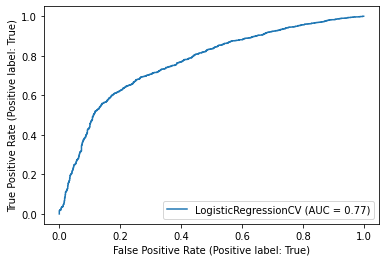

In [ ]:
from sklearn.metrics import plot_roc_curve

plot_roc_curve(model, X_train, y_train)

### Evaluate the CV Performance of the Model

In [ ]:
from sklearn.model_selection import cross_validate

model = LogisticRegressionCV()
cv_results = cross_validate(model, X_train, y_train, cv=10, scoring=['accuracy', 'f1_macro', 'roc_auc'])
print(f'Accuracy: {np.mean(cv_results["test_accuracy"])}')
print(f'AUC: {np.mean(cv_results["test_roc_auc"])}')
print(f'Macro F1: {np.mean(cv_results["test_f1_macro"])}')

Accuracy: 0.7545814953059609
AUC: 0.7567641472064508
Macro F1: 0.5925332201513649


### Predict on the test data (S19)

In [ ]:
early_test = pd.read_csv(os.path.join(TEST_PATH, 'early.csv'))
late_test = pd.read_csv(os.path.join(TEST_PATH, 'late.csv'))
X_test = extract_features(late_test, early_test, scaler, False)

In [ ]:
X_test.shape

(1511, 25)

When writing output to be judged, make sure to **output probabilities** for the positive class, so that we can calculate AUC when judging!

In [ ]:
model = LogisticRegressionCV()
model.fit(X_train, y_train)
# Note the use of predict_proba (the [:,1] gets the positive probabilities)
predictions = model.predict_proba(X_test)[:,1]

In [ ]:
predictions


array([0.71870299, 0.63676216, 0.80529838, ..., 0.7270374 , 0.70659839,
       0.69141046])

In [ ]:
predictions_df = late_test.copy()
predictions_df['Label'] = predictions
predictions_df

,SubjectID,AssignmentID,ProblemID,Label
0,036ad3e516c5bf3a4b3be35b137bcbb8,494.0,41,0.718703
1,036ad3e516c5bf3a4b3be35b137bcbb8,494.0,43,0.636762
2,036ad3e516c5bf3a4b3be35b137bcbb8,494.0,44,0.805298
3,036ad3e516c5bf3a4b3be35b137bcbb8,494.0,46,0.618494
4,036ad3e516c5bf3a4b3be35b137bcbb8,494.0,49,0.663353
...,...,...,...,...
1506,fc5f86251458722c799d1830fa0c2c1f,494.0,67,0.756331
1507,fc5f86251458722c799d1830fa0c2c1f,494.0,104,0.765930
1508,fc5f86251458722c799d1830fa0c2c1f,494.0,106,0.727037
1509,fc5f86251458722c799d1830fa0c2c1f,494.0,107,0.706598


# TESTING

In [ ]:
# We don't have the test labels - you have to submit to evaluate it

In [ ]:
# # We use res/predictions.csv, since that's where the scoring rogram expects it
# # but you can change this directory
# path = os.path.join('data', 'Prediction', semester, 'basic_LR_task1', 'res')
# os.makedirs(path, exist_ok=True)
# predictions_df.to_csv(os.path.join(path, 'predictions.csv'), index=False)

### Predict on the test data for the next semester (F19)

---



Here we see if our model will still be useful next semester. Again, we don't have labels for this test dataset, so we'll have to submit to see how well we did.

Later in the year, there will be training data released for F19, which will be tested on a different track (not cross-semester).

In [ ]:
F19_TEST_PATH = '/content/drive/Shareddrives/Learning Analytics/data/Release/F19/Test'


In [ ]:
early_test = pd.read_csv(os.path.join(F19_TEST_PATH, 'early.csv'))
late_test = pd.read_csv(os.path.join(F19_TEST_PATH, 'late.csv'))
X_test = extract_features(late_test, early_test, scaler, False)

In [ ]:
X_test.shape


(2365, 25)

In [ ]:
model = LogisticRegressionCV()
model.fit(X_train, y_train)
predictions = model.predict_proba(X_test)[:,1]

In [ ]:
predictions

array([0.81344772, 0.74948573, 0.87591233, ..., 0.40992631, 0.37947527,
       0.35654374])

In [ ]:
predictions_df = late_test.copy()
predictions_df['Label'] = predictions
predictions_df

,SubjectID,AssignmentID,ProblemID,Label
0,00358c94503a8d9e6869efc6e5cdb0e1c8e9eb39b1fd46...,494,41,0.813448
1,00358c94503a8d9e6869efc6e5cdb0e1c8e9eb39b1fd46...,494,43,0.749486
2,00358c94503a8d9e6869efc6e5cdb0e1c8e9eb39b1fd46...,494,44,0.875912
3,00358c94503a8d9e6869efc6e5cdb0e1c8e9eb39b1fd46...,494,46,0.734523
4,00358c94503a8d9e6869efc6e5cdb0e1c8e9eb39b1fd46...,494,49,0.770795
...,...,...,...,...
2360,fa7805c1d46ef49851de43750a665a993eef750b560159...,502,64,0.432782
2361,fa7805c1d46ef49851de43750a665a993eef750b560159...,502,70,0.256144
2362,fa7805c1d46ef49851de43750a665a993eef750b560159...,502,71,0.409926
2363,fa7805c1d46ef49851de43750a665a993eef750b560159...,502,112,0.379475


In [ ]:
# We don't have the test labels - you have to submit to evaluate it


In [ ]:

# THIS IS TO SAVE PREDICTIONS NOT USE YET
path = os.path.join('data', 'Prediction', 'F19', 'basic_LR_task1', 'res')
os.makedirs(path, exist_ok=True)
predictions_df.to_csv(os.path.join(path, 'predictions.csv'), index=False)

#

### Get codetable


In [ ]:
train_semester = 'S19'
test_semester = 'F19'
BASE_PATH = os.path.join('data', 'Release', train_semester)
TRAIN_PATH = os.path.join(BASE_PATH, 'Train')
TEST_PATH = os.path.join('data', 'Release', test_semester, 'Test')

if test_semester == 'F19':
    phase = 'Phase1' if train_semester == 'S19' else 'Phase2'
else:
    phase = 'Practice' if train_semester == 'F19' else 'Backwards'
phase

'Phase1'

In [ ]:
def get_code_table(ps2_dataset):
    events_table = ps2_dataset.get_main_table()
    code_states = ps2_dataset.get_code_states_table()
    runs = events_table.merge(code_states, on=PS2.CodeStateID)
    runs = runs[runs[PS2.EventType] == 'Run.Program']
    runs = runs[[PS2.Order, PS2.SubjectID, PS2.ProblemID, 'Code']]
    return runs

In [ ]:
code_table_train = get_code_table(train_ps2)
code_table_train

In [ ]:
train_ps2.get_main_table()

In [ ]:
# Some empty strings got imported as "NaN", so we turn them bcak
code_table_train['Code'][code_table_train['Code'].apply(lambda x: not isinstance(x, str))] = ""

In [ ]:
# We want to find a consistent, common vocabulary across all problems
# so we first build our vocabulary for all code submissions

from sklearn.feature_extraction.text import TfidfVectorizer

# Note this approach is _very_ naive, since it's using NLP assumptions
# about tokenizing, among other things, but it is good enough for a demonstration.
code_vectorizer = TfidfVectorizer(max_features=30)
code_vectorizer.fit(code_table_train['Code'])
top_vocab = code_vectorizer.vocabulary_
top_vocab

{'10': 0,
 '21': 1,
 'big': 2,
 'boolean': 3,
 'charat': 4,
 'count': 5,
 'day': 6,
 'else': 7,
 'end': 8,
 'equals': 9,
 'false': 10,
 'for': 11,
 'goal': 12,
 'if': 13,
 'int': 14,
 'length': 15,
 'new': 16,
 'num': 17,
 'nums': 18,
 'public': 19,
 'result': 20,
 'return': 21,
 'small': 22,
 'speed': 23,
 'str': 24,
 'string': 25,
 'substring': 26,
 'sum': 27,
 'true': 28,
 'word': 29}

In [ ]:
# We want to create a separate encoder for each problem, since the
# "document frequency" part of TF-IDF should be calibrated separately
# for each problem.
code_problem_encoders = {}
def create_encoder(rows):
    code = rows['Code']
    problem_id = rows[PS2.ProblemID].iloc[0]
    code_vectorizer = TfidfVectorizer(vocabulary=top_vocab)
    code_vectorizer.fit(code)
    code_problem_encoders[problem_id] = code_vectorizer
    
code_table_train.groupby(PS2.ProblemID).apply(create_encoder)
len(code_problem_encoders)

50

In [ ]:
test_code = code_table_train['Code'].iloc[0]
print(test_code)
print(code_problem_encoders[1].transform([test_code]))

public int sortaSum(int a, int b)
{
    if (a + b >= 10)
    {
        if (a + b <= 19)
        {
            return 20;
        }
        return a + b;
    }
    else
    {
        return a + b;
    }
}

  (0, 21)	0.5929619322827931
  (0, 19)	0.19320378937452193
  (0, 14)	0.5796113681235658
  (0, 13)	0.39681148818701084
  (0, 7)	0.2744965584355051
  (0, 0)	0.20569731847202877


In [ ]:
extract_instance_features(X_train_base.iloc[0], early_train)

AssignmentID                494.0
ProblemID                      41
ProblemsAttempted              30
PercCorrectEventually         1.0
MedAttempts                   6.5
MaxAttempts                    45
PercCorrectFirstTry      0.166667
Name: 0, dtype: object

In [ ]:
def extract_instance_code_features(instance, early_df, code_table):
    subject_id = instance[PS2.SubjectID]
    problem_id = instance[PS2.ProblemID]
    
    # Get all attempts for this problem by this subject
    attempts = code_table[(code_table[PS2.SubjectID] == subject_id) & \
                          (code_table[PS2.ProblemID] == problem_id)]
    # Get the code of the last attempt (we could use others but don't here)
    encoder = code_problem_encoders[problem_id]
    # If for some reason there were no attempts, return 0s
    if (attempts.shape[0] == 0):
        return encoder.transform([""])
    last_attempt = attempts.sort_values('Order')['Code'].iloc[-1]
    code_features = encoder.transform([last_attempt])
    
    return code_features

In [ ]:
print(extract_instance_code_features(X_train_base.iloc[0], early_train, code_table_train))

  (0, 21)	0.22116095645566827
  (0, 19)	0.2128142305637896
  (0, 18)	0.8512569222551584
  (0, 14)	0.4256284611275792


In [ ]:
from scipy.sparse import vstack
import functools

code_features = X_train_base.iloc[:5].apply(\
    lambda instance: extract_instance_code_features(\
        instance, early_train, code_table_train), axis=1)

vstack(code_features)

<5x30 sparse matrix of type '<class 'numpy.float64'>'
	with 37 stored elements in Compressed Sparse Row format>

In [ ]:
def extract_features(X, early_df, code_table, scaler, is_train):
    # First extract performance features for each row
    features = X.apply(lambda instance: extract_instance_features(instance, early_df), axis=1)
    # Then get code features
    code_features = X.apply(lambda instance: extract_instance_code_features(\
            instance, early_df, code_table), axis=1)
    code_features = vstack(code_features).toarray()
    
    # Then one-hot encode the problem_id and append it
    problem_ids = problem_encoder.transform(features[PS2.ProblemID].values.reshape(-1, 1)).toarray()
    # Then get rid of nominal features
    features.drop([PS2.AssignmentID, PS2.ProblemID], axis=1, inplace=True)
    # Then scale the continuous features, fitting the scaler if this is training
    if is_train:
        scaler.fit(features)
    features = scaler.transform(features)
    
    # Return continuous and one-hot features together
    return np.concatenate([features, code_features, problem_ids], axis=1)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = extract_features(X_train_base, early_train, code_table_train, scaler, True)

In [ ]:
print(X_train.shape)
X_train[:2,]

(4201, 55)


array([[ 0.51751812,  0.58371895,  1.76922077,  1.70602676, -0.89569333,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.42562846,
         0.        ,  0.        ,  0.        ,  0.85125692,  0.21281423,
         0.        ,  0.22116096,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.51751812,  0.58371895,  1.76922077,  1.70602676, -0.89569333,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.26622699,  0.

Evaluate the Training Performance of the Model MPL and RANDO FOREST CLASSIFIER



In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

# We set an alpha value; otherwise the model overfits with 100% accuracy
# If we were being rigorous, we would set this using hyperparameter tuning
model = LogisticRegression(solver='lbfgs', max_iter=1000)
model.fit(X_train, y_train)
train_predictions = model.predict(X_train)

In [ ]:

print(classification_report(train_predictions, y_train))
print('AUC: ' + str(roc_auc_score(train_predictions, y_train)))
print('Macro F1: ' + str(f1_score(train_predictions, y_train, average='macro')))

              precision    recall  f1-score   support

       False       0.29      0.60      0.39       528
        True       0.93      0.79      0.86      3673

    accuracy                           0.77      4201
   macro avg       0.61      0.69      0.62      4201
weighted avg       0.85      0.77      0.80      4201

AUC: 0.6936126339628246
Macro F1: 0.6230972054217814


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


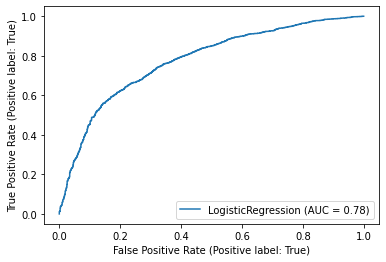

In [ ]:
from sklearn.metrics import plot_roc_curve

plot_roc_curve(model, X_train, y_train)

In [ ]:
# Look at which features were important
print(np.argsort(model.feature_importances_))
model.feature_importances_

[31 17  6  9 28 11 34 29  7 45 49 27 41 14 40 39 36 46 48 38 53 42 54 50
 25 22 43 13 51 35 30 44 47 52 10  5 37 32 15  8 12 21 33  0 23 16 18 19
 26 20 24  3  1  2  4]


array([2.37290791e-02, 1.23244007e-01, 1.31862365e-01, 8.70680947e-02,
       1.63895344e-01, 8.25996733e-03, 0.00000000e+00, 2.13886856e-04,
       1.63144456e-02, 0.00000000e+00, 4.32918585e-03, 0.00000000e+00,
       1.86553264e-02, 2.75563715e-03, 8.39629224e-04, 1.07649975e-02,
       2.95417435e-02, 0.00000000e+00, 3.52350506e-02, 4.21194012e-02,
       5.00149505e-02, 1.88885204e-02, 2.30247734e-03, 2.68090190e-02,
       8.17219707e-02, 2.26899277e-03, 4.30937983e-02, 7.64706339e-04,
       0.00000000e+00, 1.47589737e-04, 3.02072492e-03, 0.00000000e+00,
       8.83400642e-03, 2.02164754e-02, 0.00000000e+00, 2.95054804e-03,
       1.05058296e-03, 8.26415800e-03, 1.33209358e-03, 1.02839185e-03,
       1.02834250e-03, 7.91777642e-04, 1.86515008e-03, 2.64055166e-03,
       3.30207483e-03, 6.02389654e-04, 1.20863433e-03, 3.37982376e-03,
       1.27549864e-03, 7.20543688e-04, 1.97872865e-03, 2.76903736e-03,
       3.45524020e-03, 1.49708984e-03, 1.94795046e-03])

In [ ]:
# The first 7 featurs are from attempts.
# The top-4 most important are from these.
extract_instance_features(X_train_base.iloc[0], early_train).index

Index(['AssignmentID', 'ProblemID', 'ProblemsAttempted',
       'PercCorrectEventually', 'MedAttempts', 'MaxAttempts',
       'PercCorrectFirstTry'],
      dtype='object')

In [ ]:
# The 5th highest importance feature is #24
# The variable name num
print(sorted(top_vocab)[24 - 7])
# public, perhaps used if declaring a helper method
print(sorted(top_vocab)[26 - 7])
# The variable name goal
print(sorted(top_vocab)[19 - 7])
# if
print(sorted(top_vocab)[20 - 7])
# for
print(sorted(top_vocab)[18 - 7])

num
public
goal
if
for


## Evaluate CV performance of the model


> Indented block

> Indented block





In [ ]:
from sklearn.model_selection import cross_validate

model = LogisticRegression(solver='lbfgs', max_iter=1000)
cv_results = cross_validate(model, X_train, y_train, cv=5, scoring=['accuracy', 'f1_macro', 'roc_auc'])
print(f'Accuracy: {np.mean(cv_results["test_accuracy"])}')
print(f'AUC: {np.mean(cv_results["test_roc_auc"])}')
print(f'Macro F1: {np.mean(cv_results["test_f1_macro"])}')

Accuracy: 0.7591065058603703
AUC: 0.7616000568978862
Macro F1: 0.6070144951849544


## Predict on test data

In [ ]:
F19_TEST_PATH = '/content/drive/Shareddrives/Learning Analytics/data/Release/F19/Test'


In [ ]:
early_test = pd.read_csv(os.path.join(F19_TEST_PATH, 'early.csv'))
late_test = pd.read_csv(os.path.join(F19_TEST_PATH, 'late.csv'))

In [ ]:

test_ps2 = ProgSnap2Dataset(os.path.join(F19_TEST_PATH, 'Data'))
code_table_test = get_code_table(test_ps2)

X_test = extract_features(late_test, early_test, code_table_test, scaler, False)

In [ ]:
X_test.shape

(2365, 55)

In [ ]:
model = LogisticRegression(solver='lbfgs', max_iter=7000)
model.fit(X_train, y_train)
predictions = model.predict_proba(X_test)[:,1]

In [ ]:
predictions

array([0.7546328 , 0.78634275, 0.85483299, ..., 0.33806247, 0.33282418,
       0.29379259])

In [ ]:
predictions_df = late_test.copy()
predictions_df['Label'] = predictions
predictions_df

,SubjectID,AssignmentID,ProblemID,Label
0,00358c94503a8d9e6869efc6e5cdb0e1c8e9eb39b1fd46...,494,41,0.754633
1,00358c94503a8d9e6869efc6e5cdb0e1c8e9eb39b1fd46...,494,43,0.786343
2,00358c94503a8d9e6869efc6e5cdb0e1c8e9eb39b1fd46...,494,44,0.854833
3,00358c94503a8d9e6869efc6e5cdb0e1c8e9eb39b1fd46...,494,46,0.693533
4,00358c94503a8d9e6869efc6e5cdb0e1c8e9eb39b1fd46...,494,49,0.769871
...,...,...,...,...
2360,fa7805c1d46ef49851de43750a665a993eef750b560159...,502,64,0.405199
2361,fa7805c1d46ef49851de43750a665a993eef750b560159...,502,70,0.221193
2362,fa7805c1d46ef49851de43750a665a993eef750b560159...,502,71,0.338062
2363,fa7805c1d46ef49851de43750a665a993eef750b560159...,502,112,0.332824


In [ ]:
~